In [105]:
import pip
import numpy as np
import pandas as pd
from itertools import permutations
from scipy.special import softmax
import cvxpy as cp
import math
from math import floor, ceil
import seaborn as sns
from matplotlib import pyplot as plt

## Define the metrics

In [43]:
def infeasible_index(ranking: pd.DataFrame,
                     groups: list[dict] | list,
                     target_prop: list,
                     r=None,
                     control_upper = True,
                     verbose=False):
    ii = 0
    r_ = len(ranking)+1 if r is None else r
    viol = np.zeros(r_)
    # find elements from that group
    group_masks = []
    if len(groups) == len(ranking):
      group_codes = pd.Series(data=groups, index=ranking.index)
    else:
      group_codes = pd.Series(index=ranking.index, dtype=float)
    
    for i_gr, group in enumerate(groups):
        if len(groups) == len(ranking):
          group_codes = pd.Series(data=groups, index=ranking.index)
        else:
          q = ' & '.join(
                          [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
                          for s_i, v_i in group.items()]
                          )
          group_masks.append(np.isin(ranking.index, (np.array(ranking.query(q).index))))
          group_codes.loc[group_masks[-1]] = i_gr

        for k in range(1, r_):
          count_ai = np.sum(group_codes.iloc[:k] == i_gr)
          lower = np.floor(k*target_prop[i_gr])
          upper = np.ceil(k*target_prop[i_gr])
          if count_ai < lower or (count_ai > upper and control_upper):
            if not viol[k-1]:
              ii+=1
            if verbose and not viol[k-1]:
              print(f'Violation on k={k} by group {i_gr}: L: {lower} Act: {count_ai} U: {upper}')
            viol[k-1]=True
    return ii

def _dcg(scores):
  # discounted cumulative gain
  scores = np.array(scores, dtype=float)
  logs = np.log2(np.arange(1, len(scores)+1)+1)
  z = np.sum(scores/logs)
  return z

def ndcg(scores, all_scores):
  return _dcg(scores) / _dcg(np.sort(all_scores[:len(scores)])[::-1])

def KT(sigma, pi):
  """
  Compute the kendall tau distance of two permutations.
  """
  length = len(pi)
  kt = 0
  for i in range(length):
    for j in range(i+1, length):
      if (sigma[i] < sigma[j] and pi[i] > pi[j]) or \
       (sigma[i] > sigma[j] and pi[i] < pi[j]):
       kt += 1
  return kt

## Define the algorithms

#### Mallows

In [3]:
class MallowsModelGenerator:
    """Mallows Model Generator."""

    def __init__(self, theta, sigma0, seed=None):
        self.i = 0
        self.theta = theta
        self.n = len(sigma0)
        self.rng = np.random.default_rng(seed=seed)

        self.init_dicts(sigma0)

        if isinstance(sigma0, pd.DataFrame):
            self.sigma0 = self.to_indices(sigma0.index)
        else:
            self.sigma0 = self.to_indices(sigma0)
        self.model(theta, self.sigma0)

    def __iter__(self):
        """
        Return iterator oject itself.

        Returns
        -------
        iterator
            DESCRIPTION.

        """
        return self

    def __next__(self):
        return self.rng.choice(self.perm, p=self.prob)

    def KT(self, sigma, pi):
        """
        Compute the kendall tau distance of two permutations.
        """
        length = len(pi)
        kt = 0
        for i in range(length):
            for j in range(i+1, length):
                if (sigma[i] < sigma[j] and pi[i] > pi[j]) or \
                        (sigma[i] > sigma[j] and pi[i] < pi[j]):
                    kt = kt+1
        return kt

    def model(self, theta, sigma0):
        """
        Create the permutations and probabilities for the Mallows model.
        """
        perm = list(permutations(sigma0))
        prob = np.zeros(len(perm))

        x = [-theta*self.KT(p, sigma0) for p in perm]
        # for i in range(len(perm)):
        #     x.append(-theta*self.KT(perm[i], sigma0))
        prob = softmax(x)
        self.perm = perm
        self.prob = prob
        return (perm, prob)

    def sample(self, centralPermStr):
        """
        Return a sample of Mallows Model given a central ranking.
        """
        isDf = isinstance(centralPermStr, pd.DataFrame)
        sigma0 = self.to_indices(centralPermStr.index if isDf else centralPermStr)
        p = next(self)
        t = self.transform(p, sigma0)
        new_sample = self.from_indices(t)
        if isDf:
            return self.dfIndexToValue.loc[new_sample]
        else:
            return new_sample

    def transform(self, p, sigma0):
        """
        Transform a permutation to another one, given the central permutation.
        """
        return np.dot(p, self.permMatrix(sigma0))

    def permMatrix(self, sigma0):
        """
        Create the permutation matrix.
        """
        I_matrix = np.eye(self.n)
        return I_matrix[sigma0].T

    def init_dicts(self, labels):
        """
        Initialize the encoding and decoding dictionaries for permutations.
        """
        isDf = isinstance(labels, pd.DataFrame)
        indexToValue = {}
        valueToIndex = {}
        if isDf:
            indexToValue = {i: labels.index[i] for i in range(len(labels.index))}
            valueToIndex = {labels.index[i]: i for i in range(len(labels.index))}
            self.indexToValue = indexToValue
            self.valueToIndex = valueToIndex
            self.dfIndexToValue = labels
        else:
            for i in range(len(labels)):
                indexToValue[i] = labels[i]
                valueToIndex[labels[i]] = i
            self.indexToValue = indexToValue
            self.valueToIndex = valueToIndex
        return indexToValue, valueToIndex

    def from_indices(self, perm):
        """
        Transformw permutations from list of indexes to strings.
        """
        ret = []
        for p in perm:
            ret.append(self.indexToValue[p])
        return ret

    def to_indices(self, perm):
        """
        Transform a permutation from an array to a list of indeces.
        """
        ret = []
        for s in perm:
            ret.append(self.valueToIndex[s])
        return ret

In [4]:
from math import floor, ceil

def prepare_items(dataset, groups, target_prop, score_label, r):
  center = pd.DataFrame(columns=dataset.columns)
  group_items = []
  group_labels = {}
  for gr_id, group in enumerate(groups):
    q = ' & '.join(
        [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
        for s_i, v_i in group.items()]
        )
    res = dataset.query(q)
    group_items.append(res)
    for i in res.index:
      group_labels[i] = gr_id
  group_counts = [0]*len(groups)
  # get minimum repr for every group
  for i in range(len(groups)):
    center = pd.concat([center, group_items[i].iloc[:floor(r*target_prop[i])]], axis=0)
    group_counts[i] += floor(r*target_prop[i])
  free_ind = dataset.index[~dataset.index.isin(center.index)]
  # fill up free spots until r or maximum repr reached for every group
  for i in free_ind:
    if len(center) == r:
      break
    cand_group = group_labels[i]
    if group_counts[cand_group] < ceil(r*target_prop[cand_group]):
        center.loc[i] = dataset.loc[i]
        group_counts[cand_group]+=1
  return center.sort_values(by=score_label, ascending=False)

In [5]:
#### Interface for the Mallows algorithm
def mallows_alg(items, groups, target_prop, theta, n_tries, r):
  center = prepare_items(items, groups, target_prop, r)
  mm = MallowsModelGenerator(theta=theta, sigma0=center)
  min_ii = len(center)+10
  for _ in range(n_tries):
    s = mm.sample(center)
    ii = infeasible_index(ranking=center, groups=groups, target_prop=target_prop)
    if ii <= min_ii:
      min_ii = ii
      best_sample = s
  return best_sample

def exact_mallows(center, theta, seed=None):
  mm = MallowsModelGenerator(theta=theta, sigma0=center, seed=None)
  return mm.sample(center)

#### Approximate Mallows

##### Slightly altered code from https://github.com/ekhiru/top-k-mallows

In [6]:
import numpy as np

def check_theta_phi(theta, phi):
    """This function automatically converts theta to phi or phi to theta as
    list or float depending on the values and value types given as input.
        Parameters
        ----------
        theta: float or list
            Dispersion parameter theta to convert to phi (can be None)
        phi: float or list
            Dispersion parameter phi to convert to theta (can be None)
        Returns
        -------
        tuple
            tuple containing both theta and phi (of list or float type depending on the input type)
    """
    if not ((phi is None) ^ (theta is None)):
        print("Set valid values for phi or theta")
    if phi is None and type(theta)!=list:
        phi = theta_to_phi(theta)
    if theta is None and type(phi)!=list:
        theta = phi_to_theta(phi)
    if phi is None and type(theta)==list:
        phi = [theta_to_phi(t) for t in theta]
    if theta is None and type(phi)==list:
        theta = [phi_to_theta(p) for p in phi]
    return np.array(theta), np.array(phi)

def theta_to_phi(theta):
    """ This functions converts theta dispersion parameter into phi
        Parameters
        ----------
        theta: float
            Real dispersion parameter
        Returns
        -------
        float
            phi real dispersion parameter
    """
    return np.exp(-theta)

def phi_to_theta(phi):
    """This functions converts phi dispersion parameter into theta
        Parameters
        ----------
        phi: float
            Real dispersion parameter
        Returns
        -------
        float
            theta real dispersion parameter
    """
    return -np.log(phi)

In [7]:
import numpy as np
import itertools as it
import scipy.optimize as sp_opt

#******** Complete rankings **********#
#*************************************#


#************* Distance **************#

def merge(left, right):
    """
    This function uses Merge sort algorithm to count the number of
    inversions in a permutation of two parts (left, right).
    Parameters
    ----------
    left: ndarray
        The first part of the permutation
    right: ndarray
        The second part of the permutation
    Returns
    -------
    result: ndarray
        The sorted permutation of the two parts
    count: int
        The number of inversions in these two parts.
    """
    result = []
    count = 0
    i, j = 0, 0
    left_len = len(left)
    while i < left_len and j < len(right):
        if left[i] <= right[j]:
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            count += left_len - i
            j += 1
    result += left[i:]
    result += right[j:]

    return result, count

def mergeSort_rec(lst):
    """
    This function splits recursively lst into sublists until sublist size is 1. Then, it calls the function merge()
    to merge all those sublists to a sorted list and compute the number of inversions used to get that sorted list.
    Finally, it returns the number of inversions in lst.
    Parameters
    ----------
    lst: ndarray
        The permutation
    Returns
    -------
    result: ndarray
        The sorted permutation
    d: int
        The number of inversions.
    """
    lst = list(lst)
    if len(lst) <= 1:
        return lst, 0
    middle = int( len(lst) / 2 )
    left, a   = mergeSort_rec(lst[:middle])
    right, b  = mergeSort_rec(lst[middle:])
    sorted_, c = merge(left, right)
    d = (a + b + c)
    return sorted_, d



def mk_distance(A, B=None):
    """
    This function computes Kendall's-tau distance between two permutations
    using Merge sort algorithm.
    If only one permutation is given, the distance will be computed with the
    identity permutation as the second permutation
   Parameters
   ----------
   A: ndarray
        The first permutation
   B: ndarray, optional
        The second permutation (default is None)
   Returns
   -------
   int
        Kendall's-tau distance between both permutations (equal to the number of inversions in their composition).
    """
    if B is None : B = list(range(len(A)))

    A = np.asarray(A).copy()
    B = np.asarray(B).copy()
    n = len(A)

    # check if A contains NaNs
    msk = np.isnan(A)
    indexes = np.array(range(n))[msk]

    if indexes.size:
        A[indexes] = n#np.nanmax(A)+1

    # check if B contains NaNs
    msk = np.isnan(B)
    indexes = np.array(range(n))[msk]

    if indexes.size:
        B[indexes] = n#np.nanmax(B)+1

    # print(A,B,n)
    inverse = np.argsort(B)
    compose = A[inverse]
    _, distance = mergeSort_rec(compose)
    return distance


def mk_max_dist(n):
    """ This function computes the maximum distance between two permutations of n length.
        Parameters
        ----------
        n: int
            Length of permutations
        Returns
        -------
        int
            Maximum distance between permutations of given n length.
    """
    return int(n*(n-1)/2)


#************ Vector/Rankings **************#

def v_to_ranking(v, n):
    """This function computes the corresponding permutation given a decomposition vector.
    The O(n log n) version in 10.1.1 of
    Arndt, J. (2010). Matters Computational: ideas, algorithms, source code.
    Springer Science & Business Media.
        Parameters
        ----------
        v: ndarray
            Decomposition vector, same length as the permutation, last item must be 0
        n: int
            Length of the permutation
        Returns
        -------
        ndarray
            The permutation corresponding to the decomposition vectors.
    """
    rem = list(range(n))
    rank = np.full(n, np.nan)
    for i in range(len(v)):
        rank[i] = rem[v[i]]
        rem.pop(v[i])
    return rank.astype(int)

def ranking_to_v(sigma, k=None):
    """This function computes the corresponding decomposition vector given a permutation
    The O(n log n) version in 10.1.1 of
    Arndt, J. (2010). Matters Computational: ideas, algorithms, source code.
    Springer Science & Business Media.
        Parameters
        ----------
        sigma: ndarray
            A permutation
        k: int, optional
            The index to perform the conversion for a partial
            top-k list
        Returns
        -------
        ndarray
            The decomposition vector corresponding to the permutation. Will be
            of length n and finish with 0.
    """
    n = len(sigma)
    if k is not None:
        sigma = sigma[:k]
        sigma = np.concatenate((sigma, np.array([np.float(i) for i in range(n) if i not in sigma])))
    V = []
    for j, sigma_j in enumerate(sigma):
        V_j = 0
        for i in range(j+1, n):
            if sigma_j > sigma[i]:
                V_j += 1
        V.append(V_j)
    return np.array(V)


#************ Sampling ************#

def mk_sample(m, n, k=None, theta=None, phi=None, s0=None):
    """This function generates m (rankings) according to Mallows Models (if the given parameters
    are m, n, k/None, theta/phi: float, s0/None) or Generalized Mallows Models (if the given
    parameters are m, n, theta/phi: ndarray, s0/None). Moreover, the parameter k allows the
    function to generate top-k rankings only.
        Parameters
        ----------
        m: int
            Number of rankings to generate
        n: int
            Length of rankings
        theta: float or ndarray, optional (if phi given)
            The dispersion parameter theta
        phi: float or ndarray, optional (if theta given)
            Dispersion parameter phi
        k: int
            Length of partial permutations (only top items)
        s0: ndarray
            Consensus ranking
        Returns
        -------
        ndarray
            The rankings generated
    """

    theta, phi = check_theta_phi(theta, phi)

    theta = np.full(n-1, theta)

    if s0 is None:
        s0 = np.array(range(n))

    rnge = np.array(range(n-1))

    psi = (1 - np.exp(( - n + rnge )*(theta[ rnge ])))/(1 - np.exp( -theta[rnge]))
    vprobs = np.zeros((n, n))
    for j in range(n-1):
        vprobs[j][0] = 1.0/psi[j]
        for r in range(1, n-j):
            vprobs[j][r] = np.exp( -theta[j] * r ) / psi[j]
    sample = []
    vs = []
    for samp in range(m):
        v = [np.random.choice(n, p=vprobs[i, :]) for i in range(n-1)]
        v += [0]
        ranking = v_to_ranking(v, n)
        sample.append(ranking)

    sample = np.array([s[s0] for s in sample])

    if k is not None:
        sample_rankings = np.array([inverse(ordering) for ordering in sample])
        sample_rankings = np.array([ran[s0] for ran in sample_rankings])
        sample = np.array([[i if i in range(k) else np.nan for i in ranking] for
                        ranking in sample_rankings])
    return sample

def num_perms_at_dist(n):
    """This function computes the number of permutations of length 1 to n for
    each possible Kendall's-tau distance d. See the online Encyclopedia of
    Integer Sequences, OEIS-A008302
        Parameters
        ----------
        n: int
            Length of the permutations
        Returns
        -------
        ndarray
            The number of permutations of length 1 to n for each possible
            Kendall's-tau distance d
    """
    sk = np.zeros((n+1, int(n*(n-1)/2+1)))
    for i in range(n+1):
        sk[i, 0] = 1
    for i in range(1, 1+n):
        for j in range(1,int(i*(i-1)/2+1)):
            if j - i >= 0 :
                sk[i, j] = sk[i,j-1]+ sk[i-1,j] - sk[i-1, j-i]
            else:
                sk[i, j] = sk[i, j-1]+ sk[i-1, j]
    return sk.astype(np.uint64)

def mk_sample_at_dist(n, dist, sk=None, sigma0=None):
    """This function randomly generates a permutation with length n at distance
    dist to a given permutation sigma0.
        Parameters
        ----------
        n: int
            Length of the permutations
        dist: int
            Distance between the permutation generated randomly and a known
            permutation sigma0
        sk: matrix
            matrix returned by the function mallows_kendall::num_perms_at_dist(n)
            if this function is to be called many times, to avoid recomputation,
            sk can be provided in the input. Otherwise, the function is called here
        sigma0: ndarray, optional
            A known permutation (If not given, then it equals the identity)
        Returns
        -------
        ndarray
            A random permutation at distance dist to sigma0.
    """
    i = 0
    probs = np.zeros(n+1)
    v = np.zeros(n, dtype=int)
    if sk is None: sk = num_perms_at_dist(n)

    while i<n and dist > 0 :
        rest_max_dist = (n - i - 1 ) * ( n - i - 2 ) / 2
        if rest_max_dist  >= dist:
            probs[0] = sk[n-i-1, dist]
        else:
            probs[0] = 0
        mi = min(dist + 1, n - i )
        for j in range(1, mi):
            if rest_max_dist + j >= dist: probs[j] = sk[n-i-1, dist-j]
            else: probs[ j ] = 0
        v[i] = np.random.choice(mi, 1, p=probs[:mi]/probs[:mi].sum())
        dist -= v[i]
        i += 1
    random_perm = v_to_ranking(v, n)

    return random_perm[sigma0].reshape(-1)

#********* Expected distance *********#

def expected_dist_mm(n, theta=None, phi=None):
    """The function computes the expected distance of Kendall's-tau distance under Mallows models (MMs).
        Parameters
        ----------
        n: int
            Length of the permutation in the considered model
        theta: float
            Real dispersion parameter, optional (if phi is given)
        phi: float
            Real dispersion parameter, optional (if theta is given)
        Returns
        -------
        float
            The expected distance under MMs.
    """
    theta, phi = check_theta_phi(theta, phi)
    rnge = np.array(range(1,n+1))
    expected_dist = n * np.exp(-theta) / (1-np.exp(-theta)) - np.sum(rnge * np.exp(-rnge*theta) / (1 - np.exp(-rnge*theta)))

    return expected_dist

#************ Variance ************#

def variance_dist_mm(n, theta=None, phi=None):
    """ This function returns the variance of Kendall's-tau distance under the MMs.
        Parameters
        ----------
        n: int
            Length of the permutations
        theta: float
            Dispersion parameter, optional (if phi is given)
        phi  : float
            Dispersion parameter, optional (if theta is given)
        Returns
        -------
        float
            The variance of Kendall's-tau distance under the MMs.

    """
    theta, phi = check_theta_phi(theta, phi)
    rnge = np.array(range(1,n+1))
    variance = (phi*n)/(1-phi)**2 - np.sum((pow(phi,rnge) * rnge**2)/(1-pow(phi,rnge))**2)

    return variance

#******** More functions *********#

def prob(sigma, sigma0, theta=None, phi=None):
    """Probability mass function of a MM with central ranking sigma0 and
    dispersion parameter theta/phi.
    Parameters
    ----------
    sigma: ndarray
        A pemutation
    sigma0: ndarray
        central permutation
    theta: float
        Dispersion parameter (optional, if phi is given)
    phi: float
        Dispersion parameter (optional, if theta is given)
    Returns
    -------
    float
        Probability mass function.
    """
    n = len(sigma)
    theta, phi = check_theta_phi(theta, phi)
    sigma0_inv = inverse(sigma0)
    rnge = np.array(range(n-1))

    psi = (1 - np.exp(( - n + rnge )*(theta)))/(1 - np.exp( -theta))
    psi = np.prod(psi)

    dist = mk_distance( compose(sigma, sigma0_inv) )

    return np.exp( - theta *  dist ) / psi

def borda_partial(rankings, w, k):
    """This function approximate the consensus ranking of a top-k rankings using Borda algorithm.
        Each nan-ranked item is assumed to have ranking $k$
        Parameters
        ----------
        rankings: ndarray
            The matrix of permutations
        w: float
            weight of each ranking
        k: int
            Length of partial permutations (only top items)
        Returns
        -------
        ndarray
            Consensus ranking.
    """
    a, b = rankings, w
    a, b = np.nan_to_num(rankings,nan=k), w
    aux = a * b
    borda = np.argsort(np.argsort(np.nanmean(aux, axis=0))).astype(float)
    mask = np.isnan(rankings).all(axis=0)
    borda[mask]=np.nan
    return borda

def psi_mm(n, theta=None, phi=None):
    """This function computes the normalization constant psi.
        Parameters
        ----------
        n: int
            Length of the permutation in the considered model
        theta: float
            Real dispersion parameter (optional if phi is given)
        phi: float
            Real dispersion parameter (optional if theta is given)
        Returns
        -------
        float
            The normalization constant psi.
    """
    rnge = np.array(range(2,n+1))
    if theta is not None:
        return np.prod((1-np.exp(-theta*rnge))/(1-np.exp(-theta)))
    if phi is not None:
        return np.prod((1-np.power(phi,rnge))/(1-phi))
    theta, phi = check_theta_phi(theta, phi)

def mk_find_phi(n, dmin, dmax):
    """Find the dispersion parameter phi that gives an expected distance between
    dmin and dmax where the length of rankings is n.
    Parameters
    ----------
    n: int
        Length of permutations
    dmin: int
        The minimum of expected distance
    dmax: int
        The maximum of expected distance
    Returns
    -------
    float
        The value of phi.
    """
    imin, imax = np.float64(0),np.float64(1)
    iterat = 0
    while iterat < 500:
        med = imin + (imax-imin)/2
        d = expected_dist_mm(n, phi_to_theta(med))
        if d < dmax and d > dmin: return med
        elif d < dmin : imin = med
        elif d > dmax : imax = med
        iterat  += 1

# end

##### permutil.py

In [8]:
import numpy as np
import itertools as it

def max_dist(n, dist_name='k'):
    if dist_name=='k': return int(n*(n-1)/2)
    if dist_name=='c': return n-1
    if dist_name=='h': return n
    if dist_name=='u': return n-1

def distance(sigma, tau=None, dist_name='k'):
    if tau is None: tau = list(range(len(sigma)))
    if dist_name == 'k':return mk_distance(sigma,tau)
    # if dist_name == 'h':return mh_distance(sigma,tau)
    if dist_name == 'c':return cayley_dist(sigma, tau)
    if dist_name == 'u':return len(sigma)-lcs_algo(sigma,tau)

def cayley_dist(sigma, pi=None):
    if pi is not None: scopy = compose(sigma, np.argsort(pi))
    else : scopy = sigma.copy()
    dist = 0
    n = len(scopy)
    sinv = np.argsort(scopy)
    for i in range(n):
        if scopy[i] != i:
            dist += 1
            j = sinv[i]
            scopy[i], scopy[j] = scopy[j], scopy[i]
            sinv[scopy[i]], sinv[scopy[j]] = sinv[scopy[j]], sinv[scopy[i]]
    return dist

def dist_to_sample(perm,P=None,dist_name='k', sample=None):
    # m param is for the re
  if dist_name=='k':
    return np.tril(P[np.ix_(np.argsort(perm),np.argsort(perm))],k=-1).sum()
  if dist_name=='h':
    return   (1-P[list(range(len(perm))),perm]).sum()
  if dist_name=='c':
    return np.sum([cayley_dist(sigma, perm) for sigma in sample])
  if dist_name=='u':
      return np.sum([distance(sigma, perm,dist_name) for sigma in sample])

def dist_to_sample_slow(perm,dist_name='k', sample=None):
    # to check the dist_to_sample works properly
    return np.sum([distance(sigma, perm, dist_name) for sigma in sample])


def sample_to_marg(sample, margtype='relative'):
    # previously called sample_to_marg_rel
  m,n = sample.shape
  P = np.zeros((n,n))
  if margtype=='relative':
      for i in range(n):
        for j in range(i+1,n):
          P[i,j] = (sample[:,i]<sample[:,j]).mean()
          P[j,i] = 1 - P[i,j]
    #   print("triangles",np.tril(P).sum(),np.tril(P).sum())
  elif margtype == 'absolute':
      for i in range(n):
          for j in range(n):
              P[i,j] = (sample[:,i]==j).sum()/m
  return P

def compose(s, p):
    """This function composes two given permutations
    Parameters
    ----------
    s: ndarray
        First permutation array
    p: ndarray
        Second permutation array
    Returns
    -------
    ndarray
        The composition of the permutations
    """
    return np.array(s[p])

def compose_partial(partial, full):
    """ This function composes a partial permutation with an other (full)
        Parameters
        ----------
        partial: ndarray
            Partial permutation (should be filled with float)
        full:
            Full permutation (should be filled with integers)
        Returns
        -------
        ndarray
            The composition of the permutations
    """
    return [partial[i] if not np.isnan(i) else np.nan for i in full]

def inverse(s):
    """ This function computes the inverse of a given permutation
        Parameters
        ----------
        s: ndarray
            A permutation array
        Returns
        -------
        ndarray
            The inverse of given permutation
    """
    return np.argsort(s)

def inverse_partial(sigma):
    """ This function computes the inverse of a given partial permutation
        Parameters
        ----------
        sigma: ndarray
            A partial permutation array (filled with float)
        Returns
        -------
        ndarray
            The inverse of given partial permutation
    """
    inv = np.full(len(sigma), np.nan)
    for i, j in enumerate(sigma):
        if not np.isnan(j):
            inv[int(j)] = i
    return inv

def select_model(mid, n):
  N = int(n*(n-1)/2) # max dist ken
  if mid == 0:
    phi = mk_find_phi(n, N/10, N/10+1)
    mname, params, mtext, mtextlong = 'mm_ken', phi , 'MM_peaked', 'Mallows model, peaked'
  elif mid == 1:
    phi = mk_find_phi(n, N/4, N/4+1)
    mname, params, mtext, mtextlong = 'mm_ken', phi , 'MM_unif', 'Mallows model, disperse'
  elif mid == 2:
    phi = mk_find_phi(n, N/10, N/10+1)
    theta = phi_to_theta(phi)
    theta = [np.exp(theta/(i+1)) for i in range(n-1)] #+ [0]
    mname, params, mtext, mtextlong = 'gmm_ken', theta , 'GMM_peaked', 'Generalized Mallows model, peaked'
  elif mid == 3:
    phi = mk_find_phi(n, N/4, N/4+1)
    theta = phi_to_theta(phi)
    theta = [theta/(i+1) for i in range(n-1)] #+ [0]
    mname, params, mtext, mtextlong = 'gmm_ken', theta , 'GMM_unif', 'Generalized Mallows model, disperse'
  elif mid == 4:
    w = np.array([np.exp(n-i) for i in range(n)])
    mname, params, mtext, mtextlong = 'pl', w , 'PL_peaked', 'Plackett-Luce, peaked'
  elif mid == 5:
    w = np.array([(n-i) for i in range(n)])
    mname, params, mtext, mtextlong = 'pl', w , 'PL_unif', 'Plackett-Luce, disperse'
  return mname, params, mtext, mtextlong


def sample(n,m,model='mm_ken', params=None):
    #m: mum perms, n: perm size; model='mm_ken'
    # sample = np.zeros((m,n))
    if model == 'mm_ken':
        return mk_sample(m=m,n=n,phi=params)
    elif model == 'pl':
        return plackett_luce_sample(m,n,w=params)
    elif model == 'gmm_ken':
        return mk_sample(m=m,n=n,theta=params)
    return

def plackett_luce_sample(m,n,w=None):
  if w is None: w = np.array([np.exp(i) for i in reversed(range(n))])
  sample = np.zeros((m,n))
  for m_ in range(m):
      ordering = []
      bucket = np.arange(n, dtype=int) #list of items to insert
      for i in range(n):
        j = np.random.choice(bucket,p=w[bucket]/w[bucket].sum())
        ordering.append(j)
        bucket = bucket[bucket!=j]
      sample[m_] = np.argsort(ordering).copy()
  return sample

def pl_proba(perm, w):
    n = len(perm)
    ordering = np.argsort(perm)
    return np.prod([  w[ordering[i]]/w[ordering[i:]].sum()  for i in range(n)])

def full_perm_path(n):
#     perm = np.random.permutation(n)
# [mk_kendall_tau(perm,p[perm]) for p in pu.full_perm_path(n)]
# ?this is alway
  perm = list(range(n))
  drifts = [perm[:]]
  while perm != list(range(n))[::-1]:
    i = np.random.choice(n-1)
    while perm[i]>perm[i+1]:
      i = np.random.choice(n-1)
    perm[i], perm[i+1] = perm[i+1],perm[i]
    drifts.append(perm[:])
  return   [np.argsort(perm) for perm in drifts]
#   [(np.argsort(perm), mk_kendall_tau(np.argsort(perm))) for perm in drifts]


def get_P(n,model='mm_ken',params=None):
  def h(k,phi):return k/(1-phi**k)
  pairw = np.empty((n,n))
  pairw[:] = np.nan
  if model=='mm_ken':
    phi = params
    # theta, phi = mk_check_theta_phi(theta, phi)
    for i in range(n):
      for j in range(i+1,n):
        pairw[i,j] = h(j-i+1,phi) - h(j-i,phi)
        pairw[j,i] = 1-pairw[i,j]
  elif model == 'pl': # generate a pairwise
    for i in range(n):
      for j in range(i+1,n):
        pairw[i,j] = params[i] / (params[i]+params[j])
        pairw[j,i] = 1-pairw[i,j]
  return pairw

# The longest common subsequence in Python


# Function to find lcs_algo
# https://www.programiz.com/dsa/longest-common-subsequence
def lcs_algo(S1, S2):
    n = m = len(S1)
    L = [[0 for x in range(n+1)] for x in range(m+1)]

    # Building the mtrix in bottom-up way
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif S1[i-1] == S2[j-1]:
                L[i][j] = L[i-1][j-1] + 1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])

    index = L[m][n]

    lcs_algo = [""] * (index+1)
    lcs_algo[index] = ""

    i = m
    j = n
    while i > 0 and j > 0:

        if S1[i-1] == S2[j-1]:
            lcs_algo[index-1] = S1[i-1]
            i -= 1
            j -= 1
            index -= 1

        elif L[i-1][j] > L[i][j-1]:
            i -= 1
        else:
            j -= 1
    return len(lcs_algo)-1
    # Printing the sub sequences
    # print("S1 : " , S1 , "\nS2 : " , S2)
    # print("LCS: " ,lcs_algo)


# S1 = np.random.permutation(range(10))
# S2 = np.random.permutation(range(10))
# m = len(S1)
# n = len(S2)
# lcs_algo(S1, S2, m, n)
# #end

#### Mallows interface

In [9]:
import numpy

def mallows_sample(theta: float, s0: pd.DataFrame, m: int=1):
  if theta == 0:
    rng = np.random.default_rng()
    return [s0.loc[rng.permutation(s0.index)] for _ in range(m)]
  else:
    n = len(s0)
    # print(m)
    center_ind = np.arange(n)
    sample = mk_sample(m=m, n=n, theta=theta, s0=center_ind)
    return [s0.iloc[ind] for ind in sample]

#### Fairness of Exposure

In [10]:
import cvxpy as cp
from math import floor
from math import ceil
from birkhoff import birkhoff_von_neumann_decomposition

if not ('GUROBI' in cp.installed_solvers()):
  pip.main(['install', 'cvxpy[GUROBI]'])

def construct_lp_foe(
    center:pd.DataFrame,
    groups: list[dict],
    target_prop: list,
    score_label: str,
    r: int=None,
    noise_rng: np.random.Generator=None,
    noise_mean: float=0,
    noise_var: float=0):
  scores = center[score_label].to_numpy()
  k = len(scores)
  if r is None:
     r = k
  s = scores
  c = 1/np.log2(1+np.arange(1,r+1))
  x = cp.Variable((k,r), nonneg=True)
  group_masks = []
  # mask elements belonging to each group
  for group in groups:
    q = ' & '.join(
                    [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
                     for s_i, v_i in group.items()]
                     )
    group_masks.append(np.isin(center.index, (np.array(center.query(q).index))))
  group_idx = [[i for i, in_group in enumerate(mask) if in_group] for mask in group_masks]
  constr1 = [cp.sum(x[i]) <= 1 for i in range(k)]
  constr2 = [cp.sum(x[:,j]) == 1 for j in range(r)]
  constraints = constr1 + constr2
  for l in range(1, r+1):
    for p, group_ind in zip(target_prop, group_idx):
      fl = floor(p*l)
      cl = ceil(p*l)
      constraints.append(cp.sum(x[group_ind,:l]) >= fl)
      constraints.append(cp.sum(x[group_ind,:l]) <= cl)
  problem = cp.Problem(cp.Maximize(c@(s@x)), constraints=constraints)
  return problem

#### Linear programming algorithm
def fairness_of_exp_alg(
    items:pd.DataFrame,
    groups: list[dict],
    target_prop: list,
    score_label: str,
    r: int,
    verbose: bool=False,
    return_problem: bool = False,
    solver: str='GUROBI',
    noise_rng: np.random.Generator=None,
    noise_mean: float=0,
    noise_var: float=0,
    is_wfair: bool = True):
  if not (len(target_prop) == len(groups)):
    raise ValueError('Must specify proportions for all groups!')
  ### make center
  if is_wfair:
    center = items
  else:
    center = prepare_items(items, groups, target_prop, 'Credit amount',r)
  ###
  problem = construct_lp_foe(center, groups, target_prop, score_label, r,
                         noise_rng,noise_mean,noise_var)
  problem.solve(verbose=verbose, solver=solver)#, QCPDual=0)#,MIPGap=1e-1,MIPGapAbs=1e-2, QCPDual=0)
  ds_matrix = list(problem.solution.primal_vars.values())[0].astype(int)
  # if 
  # return birkhoff_von_neumann_decomposition()
  print(ds_matrix)
  return birkhoff_von_neumann_decomposition(ds_matrix)
  
  # new_index = center.index @ perm_matrix
  # rerank = center.loc[new_index]
  # for column in center.columns:
  #    rerank[column] = pd.Series(np.array(center[column]) @ perm_matrix)


  # if return_problem:
  #    return rerank, problem
  # else:
  #    return rerank

#### ILP


In [11]:
import cvxpy as cp
from math import floor
from math import ceil

if not ('GUROBI' in cp.installed_solvers()):
  pip.main(['install', 'cvxpy[GUROBI]'])

# def construct_lp_OLD(
#     center:pd.DataFrame,
#     groups: list[dict],
#     target_prop: list,
#     score_label: str,):
#   scores = center[score_label].to_numpy()
#   k = len(scores)
#   s = scores
#   c = 1/np.log2(1+np.arange(1,k+1))
#   x = cp.Variable((k,k), boolean=True)
#   group_masks = []
#   # mask elements belonging to each group
#   for group in groups:
#     q = ' & '.join(
#                     [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
#                      for s_i, v_i in group.items()]
#                      )
#     group_masks.append(np.isin(center.index, (np.array(center.query(q).index))))
#   group_idx = [[i for i, in_group in enumerate(mask) if in_group] for mask in group_masks]
#   constr1 = [cp.sum(x[j]) == 1 for j in range(k)]
#   constr2 = [cp.sum(x[:,i]) == 1 for i in range(k)]
#   constraints = constr1 + constr2
#   for l in range(1, k+1):
#     for p, group_ind in zip(target_prop, group_idx):
#       fl = floor(p*l)
#       cl = ceil(p*l)
#       if not (noise_rng is None):
#         fl += noise_rng.uniform()
#       constraints.append(cp.sum(x[group_ind,:l]) >= fl)
#       constraints.append(cp.sum(x[group_ind,:l]) <= cl)
#   problem = cp.Problem(cp.Maximize(c@(s@x)), constraints=constraints)
#   return problem

def construct_lp(
    center:pd.DataFrame,
    groups: list[dict],
    target_prop: list,
    score_label: str,
    r: int=None,
    noise_rng: np.random.Generator=None,
    noise_mean: float=0,
    noise_var: float=0):
  scores = center[score_label].to_numpy()
  k = len(scores)
  if r is None:
     r = k
  s = scores
  c = 1/np.log2(1+np.arange(1,r+1))
  x = cp.Variable((k,r), boolean=True)
  group_masks = []
  # mask elements belonging to each group
  for group in groups:
    q = ' & '.join(
                    [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
                     for s_i, v_i in group.items()]
                     )
    group_masks.append(np.isin(center.index, (np.array(center.query(q).index))))
  group_idx = [[i for i, in_group in enumerate(mask) if in_group] for mask in group_masks]
  constr1 = [cp.sum(x[i]) <= 1 for i in range(k)]
  constr2 = [cp.sum(x[:,j]) == 1 for j in range(r)]
  constraints = constr1 + constr2
  for l in range(1, r+1):
    for p, group_ind in zip(target_prop, group_idx):
      fl = floor(p*l)
      cl = ceil(p*l)
      if not (noise_rng is None):
        fl -= np.abs(noise_rng.normal(noise_mean, noise_var))
        cl += np.abs(noise_rng.normal(noise_mean, noise_var))
      constraints.append(cp.sum(x[group_ind,:l]) >= fl)
      constraints.append(cp.sum(x[group_ind,:l]) <= cl)
  problem = cp.Problem(cp.Maximize(c@(s@x)), constraints=constraints)
  return problem

#### Linear programming algorithm
def linprog_alg(
    items:pd.DataFrame,
    groups: list[dict],
    target_prop: list,
    score_label: str,
    r: int,
    verbose: bool=False,
    return_problem: bool = False,
    solver: str='GUROBI',
    noise_rng: np.random.Generator=None,
    noise_mean: float=0,
    noise_var: float=0,
    is_wfair: bool = False):
  if not (len(target_prop) == len(groups)):
    raise ValueError('Must specify proportions for all groups!')
  ### make center
  if is_wfair:
    center = items
  else:
    center = prepare_items(items, groups, target_prop, 'Credit amount',r)
  ###
  problem = construct_lp(center, groups, target_prop, score_label, r,
                         noise_rng,noise_mean,noise_var)
  problem.solve(verbose=verbose, solver=solver)#, QCPDual=0)#,MIPGap=1e-1,MIPGapAbs=1e-2, QCPDual=0)
  perm_matrix = list(problem.solution.primal_vars.values())[0].astype(int)
  new_index = center.index @ perm_matrix
  rerank = center.loc[new_index]
  # for column in center.columns:
  #    rerank[column] = pd.Series(np.array(center[column]) @ perm_matrix)
  if return_problem:
     return rerank, problem
  else:
     return rerank

#### Merge

In [12]:
#### Mergesort-inspired algorithm
def merge_alg(center:pd.DataFrame, target_prop, score_label, s_label, n, rng=None):
  group_candidates = [center[center[s_label] == a] for a in target_prop.keys()]
  group_candidates = [
      g.sort_values(by=score_label, ascending=False)for g in group_candidates
  ]
  groups_idx = list(range(len(target_prop.keys())))
  res = pd.DataFrame(columns = center.columns)
  if rng is None:
    rng = np.random.default_rng()
  next_cand_idx = {i: 0 for i in groups_idx}
  k = 0
  props = np.array(list(target_prop.values()))
  for k in range(n):
    choice = rng.choice(groups_idx, p=props)
    res = pd.concat(
        [res,group_candidates[choice].iloc[next_cand_idx[choice]].to_frame().T])
    if next_cand_idx[choice] == group_candidates[choice].shape[0] - 1:
      props += props[choice]/(len(props)-1)
      props[choice] = 0
      next_cand_idx.pop(choice)
    else:
      next_cand_idx[choice] += 1
  return res

#### DetConstSort


In [13]:
def linkedin_alg(items: pd.DataFrame,
                 groups: list[dict],
                 target_prop: dict | list,
                 score_label: str,
                 r: int,
                #  s_label: str,
                 noise_rng: np.random.Generator=None,
                 noise_mean: float=None,
                 noise_var: float=None):
  rankedItems, maxIndices = [], []
  item_groups = []
  for group in groups:
     q = ' & '.join(
                    [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
                     for s_i, v_i in group.items()]
                     )
     item_groups.append(items.query(q))
  n_groups = len(target_prop)
  group_counts, min_counts = [0] * n_groups, [0] * n_groups
  lastEmpty, k = 0, 0
  while lastEmpty < r:
    k+=1
    # determine the minimum feasible counts of each group at current rec. list size
    min_counts_at_k = [
        math.floor(p_gi*k) + (noise_rng.normal(noise_mean,noise_var) if noise_rng is not None else 0)
        for p_gi in target_prop]
    # get sensitive attr. values for which the current minimum count has increased
    # since last one
    changed_mins = []
    for group_idx in range(n_groups):
      if min_counts_at_k[group_idx] > min_counts[group_idx]:
        changed_mins.append(group_idx)
    if len(changed_mins) > 0:
      # get the list of candidates to insert and sort them by their score
      changed_items = []
      # save the candidate AND the index of the group it belongs to
      for group_idx in changed_mins:
        if group_counts[group_idx] < len(item_groups[group_idx]):
          changed_items.append((group_idx, item_groups[group_idx].iloc[group_counts[group_idx]]))
      changed_items.sort(key=lambda x: x[1][score_label],reverse=True)
      # print(changed_items)
      # add the candidate items, starting with the best score
      for newitem in changed_items:
        if len(rankedItems) == r:
          break
        maxIndices.append(k-1)
        rankedItems.append(newitem[1])
        start = lastEmpty
        while start > 0 and maxIndices[start-1] >= start and rankedItems[start-1][score_label] < rankedItems[start][score_label]:
          maxIndices[start-1], maxIndices[start] = maxIndices[start], maxIndices[start-1]
          rankedItems[start-1], rankedItems[start] = rankedItems[start], rankedItems[start-1]
          start -= 1
        lastEmpty+=1
        group_counts[newitem[0]] += 1
      min_counts = min_counts_at_k
  return pd.DataFrame(rankedItems)

#### GrBinaryIPF

In [14]:
# from:
# https://github.com/MouinulIslamNJIT/Rank-Aggregation_Proportionate_Fairness/
def GrBinaryIPF(rank,group, verbose=False):
    Rho0 = []
    Rho1 = []
    for i in rank:
        if group[i] == 1:
            Rho0.append(i)
        else:
            Rho1.append(i)

    j = 1
    rankDic = {}
    for itm in rank:
        rankDic[itm] = j
        j = j + 1

    urgent = []
    Rout = []
    P1count = 0
    P0count = 0

    Fp0 = len(Rho0)/len(rank)
    Fp1 = len(Rho1)/len(rank)

    i = 1
    while len(Rho0) != 0 or len(Rho1) != 0:
        if verbose: print(Rout)
        if P1count >= len(Rho1):
            Rout.extend(Rho0[P0count:len(Rho0)])
            return Rout
        if P1count >= len(Rho0):
            Rout.extend(Rho1[P1count:len(Rho1)])
            return Rout

        if len(urgent) == 0:
            if rankDic[Rho1[P1count]] < rankDic[Rho0[P0count]]:
                Rout.append(Rho1[P1count])
                P1count = P1count + 1
            else:
                Rout.append(Rho0[P0count])
                P0count = P0count + 1
        else:
            if urgent[0] == 'P1':
                Rout.append(Rho1[P1count])
                P1count = P1count + 1
            else:
                Rout.append(Rho0[P0count])
                P0count = P0count + 1
            urgent = []
        # update urgent
        if Fp1 * (i + 1) - P1count >= 1:
            urgent.append('P1')

        if Fp0 * (i + 1) - P0count >= 1:
            urgent.append('P0')
        i = i + 1
    return  Rout

#### ApproxMultiValuedIPF

In [97]:
import networkx as nx
import math
import numpy as np

def ApproxMultiValuedIPF(data, pr_attr_name, score_attr_name, r, noise_rng=None, noise_mean=None, noise_var=None):
    # data = df.sort_values(by=score_attr_name,ascending=False)
    sens_attr = list(data[pr_attr_name])
    # print(sens_attr)
    score = list(data[score_attr_name])
    candidateId = list(data.index)

    allGenre = []
    group = []
    groupId = []
    for g in sens_attr:
        if g not in allGenre:
            allGenre.append(g)
        groupId.append(allGenre.index(g))
    # print(allGenre)

    all_items = []
    for i in range(0,len(candidateId)):
        all_items.append((score[i],candidateId[i],groupId[i]))

    all_items.sort(reverse=True)

    rank = []
    i = 1
    group = []
    # rank: position of each candidate in the ranking, starting from 1
    # group: group of that candidate
    for item in all_items:
        rank.append(i)
        group.append(item[2])
        i += 1

    rank = rank[:r]
    group = group[:r]

    numberOfItems = len(rank)
    rankGrp = {}
    # group of element on rank i
    for i in range(0, len(rank)):
        rankGrp[rank[i]] = group[i]

    grpCount = {}
    for i in group:
        grpCount[i] = 0

    rankGrpPos = {}
    # count of group of each candidate up to its position
    for i in rank:
        grpCount[rankGrp[i]] = grpCount[rankGrp[i]] + 1
        rankGrpPos[i] = grpCount[rankGrp[i]]

    rankRange = {}
    for item in rank:
        i = rankGrpPos[item]
        n = numberOfItems
        fp = grpCount[rankGrp[item]]
        r1 = math.floor((i-1) * n / fp)+1
        r2 = math.ceil(i * n / fp)
        if r2 > numberOfItems:
            r2 = numberOfItems
        rankRange[item] = (r1, r2)

    B = nx.Graph()
    top_nodes = []
    bottom_nodes = []

    for i in rank:
        top_nodes.append(i)
        bottom_nodes.append(str(i))
    B.add_nodes_from(top_nodes, bipartite=0)
    B.add_nodes_from(bottom_nodes, bipartite=1)

    for i in rank:
        r1, r2 = rankRange[i]
        for j in range(1, numberOfItems + 1):
            if j >= r1 and j <= r2:
                B.add_edge(i, str(j), weight=abs(i - j) + 0 if noise_rng is None else noise_rng.normal(noise_mean, noise_var))
            else:
                B.add_edge(i, str(j), weight=1000000000000)

    my_matching = nx.algorithms.bipartite.minimum_weight_full_matching(B, top_nodes, "weight")
    # print(my_matching)

    old_idx = list(data.index)
    new_idx = np.zeros(len(my_matching)//2)
    i=0
    for old_i, new_i in my_matching.items():
        new_idx[int(new_i) - 1] = old_idx[old_i-1]
        # res.iloc[int(new_idx)-1] = df.iloc[old_idx-1]
        i+=1
        if i == r:
            break
    res = data.loc[new_idx].copy()

    return res

## Experiment 1: Start from II

In [38]:
theta_range = np.arange(2.26, step=0.25)
group_sizes = [5,5]
prop = {0: 0.5, 1: 0.5}
n = np.sum(group_sizes)
n_mallows_samples = 20

Generate centers (randomly sample until we get one with correct II).

With 2 equally sized groups, there's only one group structure for each II value.

In [40]:
s1 = ['a']*5
s2 = ['b']*5
center = pd.Series(s1+s2)
samples = mallows_sample(theta=0, s0=center, m=100)
n_center_samples = 1
ii_samples = {}
ii_samples_group_struct = {}

for s in samples:
    group_structure = (samples[0] == 'b').to_numpy()
    ii = infeasible_index(pd.DataFrame(s,columns=['sens']), [{'sens':'a'}, {'sens': 'b'}], target_prop=[0.5,0.5])
    if ii in ii_samples.keys():
        for smpl_gs in ii_samples_group_struct[ii]:
            if (group_structure == smpl_gs).all():
                break
            else:
                ii_samples[ii].append(s.index)
                ii_samples_group_struct[ii].append(group_structure)
    else:
        ii_samples[ii] = []
        ii_samples[ii].append(s.index)
        ii_samples_group_struct[ii] = []
        ii_samples_group_struct[ii].append(group_structure)

Run the experiment: sample the Mallows distribution centered on each of the initial rankings

In [41]:
mallows_results = pd.DataFrame(index=pd.MultiIndex.from_product([
    theta_range,
    range(max(ii_samples.keys())+1),
    range(n_center_samples),
    range(n_mallows_samples)]),columns=['ii'])

for theta in theta_range:
    for center_ii in ii_samples.keys():
        for i_c, center_sample in enumerate(ii_samples[center_ii][:n_center_samples]):
            samples = mallows_sample(theta=theta, s0=center.loc[center_sample], m=40)
            for i_s ,sample in enumerate(samples):
                ii = infeasible_index(
                    pd.DataFrame(sample,columns=['sens']), [{'sens':'a'}, {'sens': 'b'}], target_prop=[0.5,0.5])
                mallows_results.loc[theta, center_ii, i_c, i_s] = ii

In [42]:
mallows_results.index.set_names(['theta', 'StartInfInd', 'Center Sample', 'Rerank Sample'], inplace=True)
mallows_results_di = mallows_results.reset_index()
mallows_results_di

,theta,StartInfInd,Center Sample,Rerank Sample,ii
0,0.00,0,0,0,6
1,0.00,0,0,1,1
2,0.00,0,0,2,4
3,0.00,0,0,3,2
4,0.00,0,0,4,3
...,...,...,...,...,...
3195,2.25,6,0,35,6
3196,2.25,6,0,36,6
3197,2.25,6,0,37,6
3198,2.25,6,0,38,6


In [43]:
mallows_results_di['Infeasible Index'] = mallows_results_di['ii']
mallows_results_di['Theta'] = mallows_results_di['theta']
mallows_results_di['Starting Infeasible Index'] = mallows_results_di['StartInfInd']
mallows_results_di['Start % Pfair Positions'] = 100 - (mallows_results_di['StartInfInd']/n*100)
mallows_results_di['% Pfair Positions'] = 100 - (mallows_results_di['ii']/n*100)

c:\Users\andre\miniconda3\envs\aif\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\andre\miniconda3\envs\aif\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


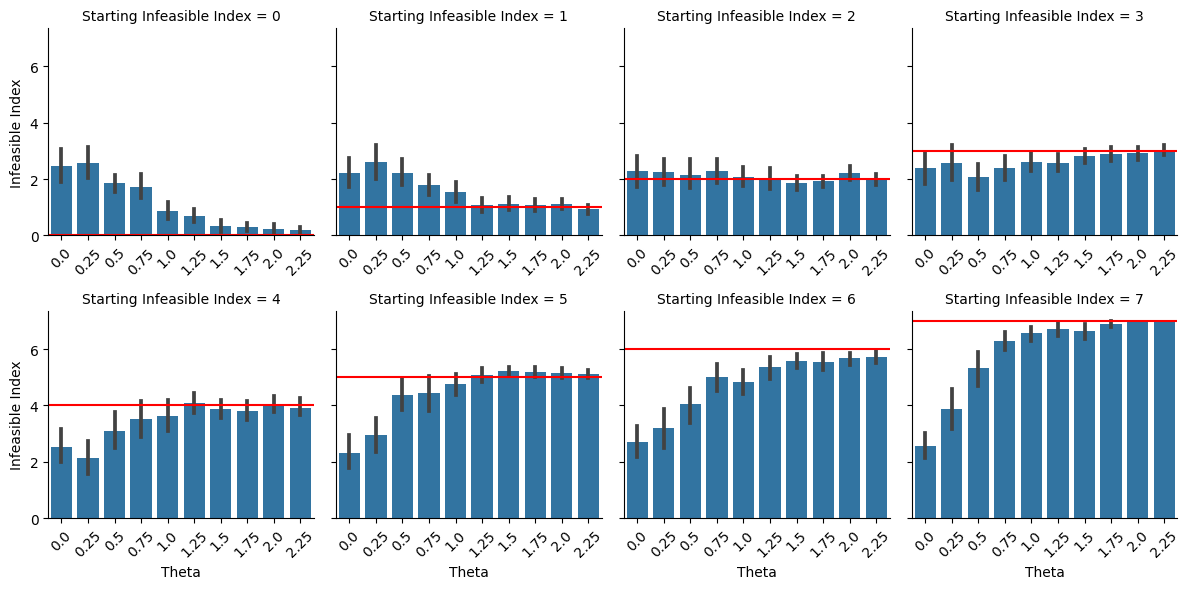

In [44]:
import seaborn as sns

gr = sns.FacetGrid(data=mallows_results_di, col='Starting Infeasible Index',col_wrap=4,sharex=False)
gr.map(sns.barplot, 'Theta', 'Infeasible Index')
for i in range(8):
    gr.facet_axis(0,i).axhline(y=i,c='red')
    gr.facet_axis(0,i).tick_params(axis='x',labelrotation=45)

gr.tight_layout()

## Experiment 2: Uniform Random Scores

In [16]:
### helper function
def calc_stats(ranking, center, groups, prop, score_label):
  ii = infeasible_index(ranking, groups, prop)
  ndcg = _dcg(ranking[score_label]/_dcg(center[score_label]))
  return ndcg, ii

mean_range = [0, 2, 4, 8]
theta_range = np.arange(2.26, step=0.25)
vars = [2,2]
group_sizes = [5,5]
prop = {0: 0.5, 1: 0.5}
n = np.sum(group_sizes)

n_center_samples = 30
n_mallows_samples = 20


def make_group(loc, scale, size, name, rng, distr='normal'):
  if distr == 'normal':
    scores = rng.normal(loc=loc, scale=scale, size=size)
  elif distr == 'unif':
    scores = rng.uniform(low=loc, high=scale, size=size)
  return pd.DataFrame(data={'score': pd.Series(scores), 'group': pd.Series([name]*size)})

def make_sample(means, vars, group_sizes, rng, distr='normal'):
  groups = []
  for mean, var, size, gname in zip(means, vars, group_sizes, range(len(means))):
    groups.append(make_group(loc=mean, scale=var, size=size, name=gname, rng=rng, distr=distr))
  sample = pd.concat(groups,ignore_index=True).sort_values(inplace=False,ascending=False,by='score')
  sample['score'] = (sample['score'] - sample['score'].min())/(sample['score'].max() - sample['score'].min())
  return sample.sort_values(by='score', ascending=False)

Generate the data and run the experiment:

In [17]:
a1 = 0
b1 = 1

rng = np.random.default_rng(seed=0)

groups = [{'group': 0},{'group': 1}]
prop = [0.5,0.5]
r_ = n

a_range = np.arange(0, 1.1, step=0.1)
b_range = np.arange(1, 2.1, step=0.1)
cols = ['NDCG', 'InfeasibleIndex']

res_mallows_u = pd.DataFrame(index=pd.MultiIndex.from_product(
    [a_range, range(n_center_samples), theta_range,range(n_mallows_samples)],
    names=['a2', 'center_sample','theta','mallows_sample']), columns=cols)
init_ii_u = pd.Series(index=pd.MultiIndex.from_product([a_range, range(n_center_samples)]))

for a2, b2 in zip(a_range, b_range):
    print(f'calculating for: {(a1, b1)}; {(a2, b2)}')
    for c_i in range(n_center_samples):
      center = make_sample([a1,a2], [b1,b2], group_sizes, rng,distr='unif')
      init_ii_u.loc[a2, c_i] = infeasible_index(center, groups, prop)
      for theta in theta_range:
        mallows_samples = mallows_sample(theta=theta, s0=center, m=n_mallows_samples)
        for sample_n in range(n_mallows_samples):
          sample_ii = infeasible_index(mallows_samples[sample_n], groups, prop)
          sample_ndcg = _dcg(mallows_samples[sample_n]['score']/_dcg(center['score']))
          res_mallows_u.loc[a2,c_i,theta,sample_n]['InfeasibleIndex'] = sample_ii
          res_mallows_u.loc[a2,c_i,theta,sample_n]['NDCG'] = sample_ndcg

res_mallows_u.to_csv('res_mallows_u.csv')

calculating for: (0, 1); (0.0, 1.0)
calculating for: (0, 1); (0.1, 1.1)
calculating for: (0, 1); (0.2, 1.2000000000000002)
calculating for: (0, 1); (0.30000000000000004, 1.3000000000000003)
calculating for: (0, 1); (0.4, 1.4000000000000004)
calculating for: (0, 1); (0.5, 1.5000000000000004)
calculating for: (0, 1); (0.6000000000000001, 1.6000000000000005)
calculating for: (0, 1); (0.7000000000000001, 1.7000000000000006)
calculating for: (0, 1); (0.8, 1.8000000000000007)
calculating for: (0, 1); (0.9, 1.9000000000000008)
calculating for: (0, 1); (1.0, 2.000000000000001)


In [18]:
init_ii_u = init_ii_u.reset_index()

Text(0, 0.5, 'Mean InfeasibleIndex')

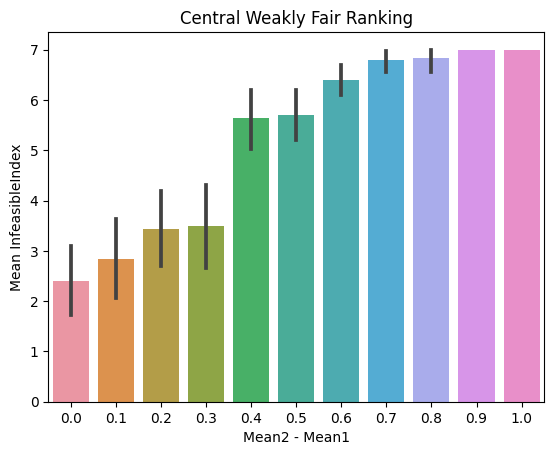

In [19]:
import seaborn as sns
from statistics import mode, median

f = sns.barplot(data=init_ii_u, x='level_0', y=0)
f.set_title('Central Weakly Fair Ranking')
f.set_xticklabels(np.round(a_range, decimals=2))
# f.tick_params(axis='x',labelrotation=90)
f.set_xlabel('Mean2 - Mean1')
f.set_ylabel('Mean InfeasibleIndex')

In [20]:
init_ii_u['%Pfair'] = 100 - init_ii_u[0]/n*100

In [21]:
res_mallows_u = pd.read_csv('res_mallows_u.csv')
res_mallows_u['Difference in Means'] = np.round(res_mallows_u['a2'],1)
res_mallows_u['Infeasible Index'] = res_mallows_u['InfeasibleIndex'] 
res_mallows_u['Theta'] = res_mallows_u['theta']
res_mallows_u['% Pfair Positions'] = 100 - (res_mallows_u['InfeasibleIndex']/n*100)

rmu = res_mallows_u.reset_index().dropna()
rmu.T

,0,1,2,3,4,5,6,7,8,9,...,65990,65991,65992,65993,65994,65995,65996,65997,65998,65999
index,0.00000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.00000,8.000000,9.000000,...,65990.000000,65991.00,65992.000000,65993.000000,65994.000000,65995.000000,65996.000000,65997.000000,65998.00,65999.00
a2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.00
center_sample,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,29.000000,29.00,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.00,29.00
theta,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,2.250000,2.25,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.25,2.25
mallows_sample,0.00000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.00000,8.000000,9.000000,...,10.000000,11.00,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.00,19.00
NDCG,0.90981,0.833408,0.884912,0.890946,0.792262,0.893862,0.728751,0.71794,0.928412,0.666801,...,0.998856,1.00,0.989314,0.993746,0.999978,0.978392,0.997956,0.991359,1.00,1.00
InfeasibleIndex,1.00000,5.000000,1.000000,4.000000,0.000000,3.000000,1.000000,1.00000,2.000000,7.000000,...,7.000000,7.00,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.00,7.00
Difference in Means,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.00
Infeasible Index,1.00000,5.000000,1.000000,4.000000,0.000000,3.000000,1.000000,1.00000,2.000000,7.000000,...,7.000000,7.00,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.00,7.00
Theta,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,2.250000,2.25,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.25,2.25


c:\Users\andre\miniconda3\envs\aif\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\andre\miniconda3\envs\aif\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


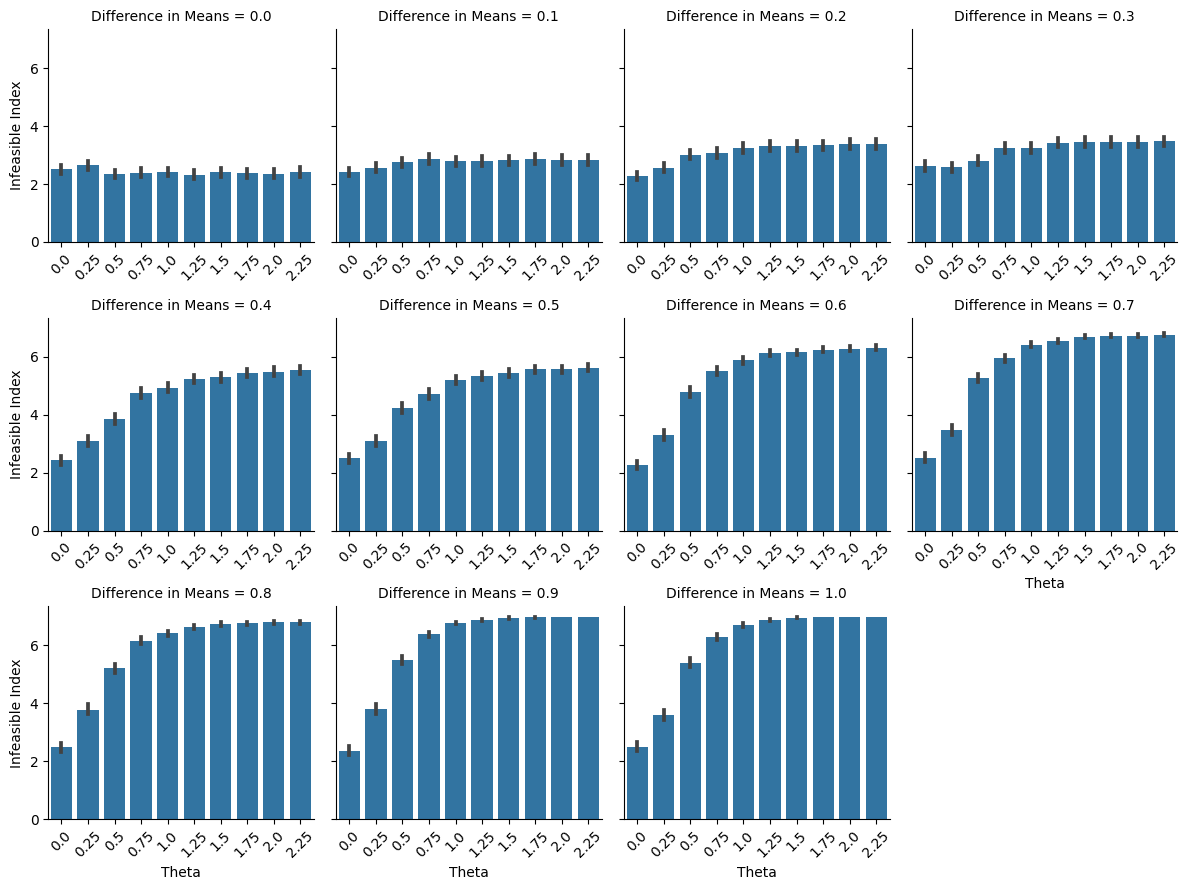

In [22]:
import seaborn as sns

gr = sns.FacetGrid(rmu, col='Difference in Means',col_wrap=4,sharex=False)
gr.map(sns.barplot, 'Theta', 'Infeasible Index')
for i in range(11):
    gr.facet_axis(0,i).tick_params(axis='x',labelrotation=45)

gr.tight_layout()
gr.savefig('mallows_means_unif_ppf_mean.png')

c:\Users\andre\miniconda3\envs\aif\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


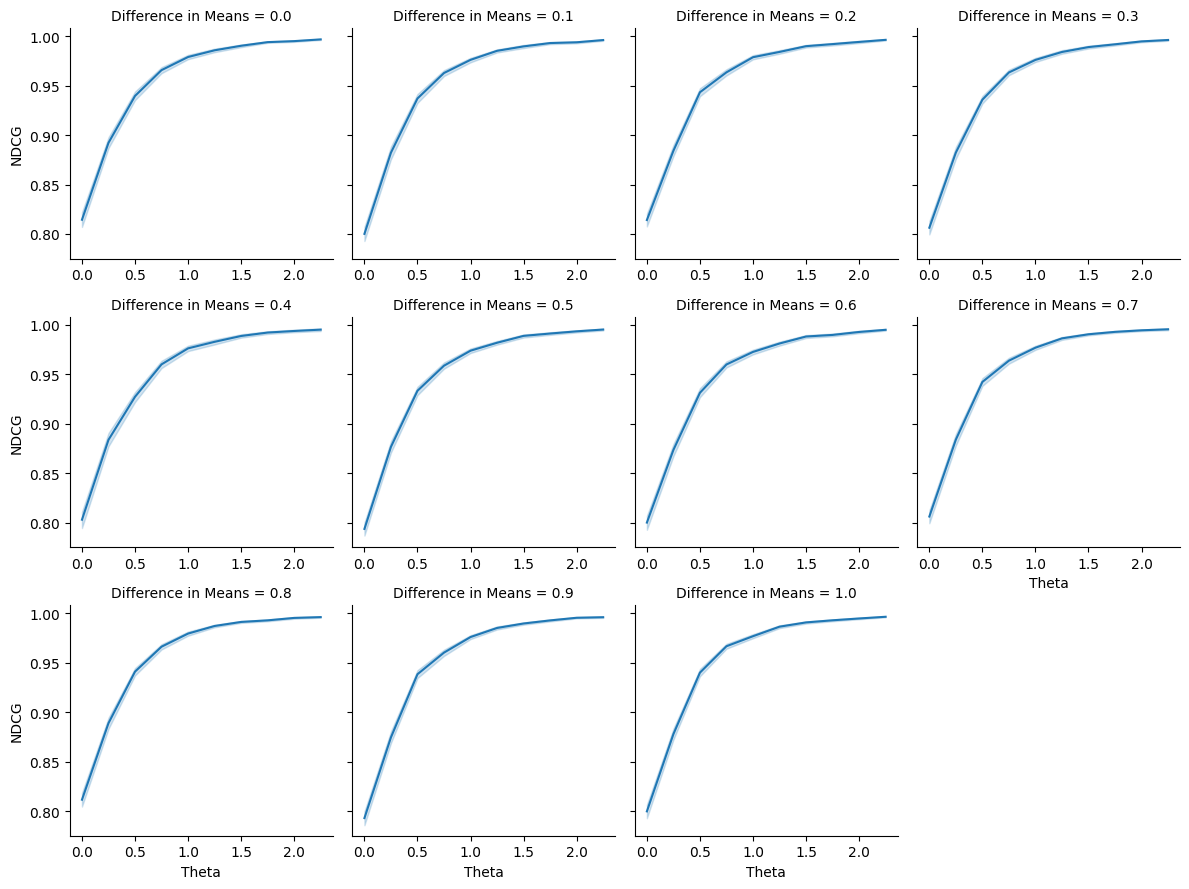

In [55]:
import seaborn as sns

grid = sns.FacetGrid(rmu, col='Difference in Means',col_wrap=4,sharex=False)
grid.map(sns.lineplot, 'Theta', 'NDCG')

grid.savefig('mallows_means_unif_ndcg_mean.png')

## Experiment 3: German Credit dataset

In [17]:
import cvxpy as cp
from math import floor
from math import ceil
import pip
if not ('GUROBI' in cp.installed_solvers()):
  pip.main(['install', 'cvxpy[GUROBI]'])
if not ('SCIP' in cp.installed_solvers()):
  pip.main(['install', 'cvxpy[SCIP]'])
cp.installed_solvers()

## IMPORTANT: If a solver is installed, but you see a "Solver _____ is not installed"
## error in the next cell, restart the session and run again

['CLARABEL',
 'CVXOPT',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'GUROBI',
 'OSQP',
 'SCIP',
 'SCIPY',
 'SCS']

#### Prepare the German Credit Dataset

In [71]:
import pandas as pd
### prepare the German Credit Dataset, rank by `credit amount`, protected attribute - age X sex ###
german = pd.read_csv('german_credit_data.csv')
german = german.drop(['Unnamed: 0', 'Job', 'Saving accounts', 'Checking account', 'Duration', 'Purpose'],axis=1)
# pd.cut() would be overkill here
# bin age
german['Age'] = german['Age'].map(lambda x: '<35' if x < 35 else '>=35')

german_groups =[{'Age': '>=35', 'Sex': 'male'},{'Age': '>=35', 'Sex':'female'},{'Age': '<35', 'Sex': 'male'}, {'Age': '<35', 'Sex': 'female'}]
german_groups_sex = [{'Sex': 'male'}, {'Sex': 'female'}]
german_groups_age = [{'Age': '>=35'}, {'Age': '<35'}]
german_groups_hou = [{'Housing': 'own'}, {'Housing': 'free'}, {'Housing': 'rent'}]
german['Age&Sex'] = german.apply(lambda x: ' '.join([x['Age'], x['Sex']]), axis=1)

german = german.sort_values(by='Credit amount', ascending=False).reset_index(drop=True)
german

,Age,Sex,Housing,Credit amount,Age&Sex
0,<35,female,own,18424,<35 female
1,>=35,male,rent,15945,>=35 male
2,>=35,male,own,15857,>=35 male
3,<35,male,own,15672,<35 male
4,<35,male,own,15653,<35 male
...,...,...,...,...,...
995,<35,female,own,343,<35 female
996,>=35,male,own,339,>=35 male
997,>=35,male,own,338,>=35 male
998,<35,male,rent,276,<35 male


Define the groups

In [72]:
def get_group_props(dataset, groups):
  props = []
  for group in groups:
    q = ' & '.join(
        [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
        for s_i, v_i in group.items()]
        )
    group_size = len(dataset.query(q))
    props.append(group_size/len(dataset))
  return props

props_sex = get_group_props(german, german_groups_sex)
props_age = get_group_props(german, german_groups_age)
props_hou = get_group_props(german, german_groups_hou)

groups = german_groups
props = get_group_props(german, groups)

In [20]:
def count_table(data, groups):
     group_masks = []
     group_df = pd.Series(index=data.index, dtype=float)
     group_name_dict = {''.join(list(group.values())): group for group in groups}
     for i_gr, group in group_name_dict.items():
          q = ' & '.join(
                         [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
                         for s_i, v_i in group.items()]
                         )
          group_masks.append(np.isin(data.index, (np.array(data.query(q).index))))
          group_df.loc[group_masks[-1]] = i_gr
     counts = []
     for k in range(1,len(data)+1):
          counts.append(group_df.astype('category').iloc[:k].value_counts(dropna=False))
     return pd.DataFrame(counts, columns=group_name_dict.keys(),index=range(1,len(data)+1))

In [106]:
rec_sizes = [10, 20, 30, 40, 50, 60, 70,80,90,100]
# rec_sizes = [10]
# rec_sizes = [10,20]
reranks = {'Mallows': {}, 'Mallows (best sample)': {}, 'ILP':{}, 'DetConstSort': {}, 'AMVIPF' : {}}
rng = np.random.default_rng(seed=0)
m = 0
v = 0
theta=1
mallows_tries = 15
trials = 1 if v == 0 else 15

for r_ in rec_sizes:
  for alg in reranks.keys():
    reranks[alg][r_] = []
  center = prepare_items(german,groups,props,'Credit amount',r_)
  rerank = mallows_sample(theta=theta, s0=center, m=mallows_tries)
  reranks['Mallows (best sample)'][r_] = rerank
  reranks['Mallows'][r_] = rerank
  for j in range(trials):
    rerank = linkedin_alg(items=center,
                          groups = groups,
                          target_prop = props, score_label='Credit amount',
                          r=r_, noise_rng=rng, noise_mean=m, noise_var=v)
    reranks['DetConstSort'][r_].append(rerank)
    try:
      rerank = linprog_alg(center,
                      groups=groups,
                      target_prop=props, score_label='Credit amount',
                      r = r_, solver='SCIP', noise_rng=rng, noise_mean=m, noise_var=v)
      reranks['ILP'][r_].append(rerank)
    except:
      reranks['ILP'][r_] = None
    rerank = ApproxMultiValuedIPF(center,
                                  'Age&Sex',
                                  'Credit amount',
                                  r_,rng,m,v)
    reranks['AMVIPF'][r_].append(rerank)

    # rerank = mallows_sample(theta=theta, s0=prepare_items(german,groups,props,'Credit amount',r))
    # rerank = mallows_sample(theta=theta, s0=prepare_items(german,groups,props,'Credit amount',r_), m=mallows_tries)
    # # reranks['Mallows (best sample)'][r].append(rerank)
    # reranks['Mallows (best sample)'][r_].append(rerank[0])
    # reranks['Mallows'][r_].append(rerank[0])

  print(r_)

10
20
30
40
50
60
70
80
90
100


#### Calculate statistics

In [107]:
res_df = pd.DataFrame(columns=[
    'Algorithm',
    'Number of Items',
    '% P-Fair Positions (Age&Sex)',
    '% P-Fair Positions (Sex)',
    '% P-Fair Positions (Age)',
    '% P-Fair Positions (Housing)',
    'NDCG',
    '% Positions Sat. Min. Representation',
    'Infeasible Index',
    'KT from Center'])

def pick_best(a, f):
  res = [0,0,0]
  for i, x in enumerate(a):
    val = f(x)
    res[2] += val
    if i == 0:
      res[1] = val
    if val > res[1]:
      res[1] = val
      res[0] = i
  res[2] /= (i+1)
  return res

j = 0
for alg in reranks.keys():
  print(alg)
  for r_ in reranks[alg].keys():
    r_rankings = reranks[alg][r_]
    if alg == 'Mallows (best sample)':
      best_ii_total = pick_best(r_rankings, lambda l: -infeasible_index(l, groups, props))
      ii = -best_ii_total[1]
      best_ii_sex = pick_best(r_rankings, lambda l: -infeasible_index(l,german_groups_sex,props_sex))
      ii_sex = -best_ii_sex[1]
      best_ii_age = pick_best(r_rankings, lambda l: -infeasible_index(l,german_groups_age,props_age))
      ii_age = -best_ii_age[1]
      best_ii_hou = pick_best(r_rankings, lambda l: -infeasible_index(l,german_groups_hou,props_hou))
      ii_hou = -best_ii_hou[1]
      best_ii_min = pick_best(r_rankings, lambda l: -infeasible_index(l,groups,props,control_upper=False))
      ii_min = -best_ii_min[1]
      best_ndcg = pick_best(r_rankings, lambda l: ndcg(l['Credit amount'], german['Credit amount']))
      gain = best_ndcg[1]
      best_kt = pick_best(r_rankings,
                            lambda l: -KT(
                                prepare_items(german, groups, props, 'Credit amount',r_).index,
                                l.index))
      kt = -best_kt[1]
      new_row = {'Algorithm': alg,
                      'Number of Items': r_,
                      '% P-Fair Positions (Age&Sex)': 100-ii/r_*100,
                      '% P-Fair Positions (Sex)': 100-ii_sex/r_*100,
                      '% P-Fair Positions (Age)': 100-ii_age/r_*100,
                      '% P-Fair Positions (Housing)': 100-ii_hou/r_*100,
                      '% Positions Sat. Min. Representation': 100-ii_min/r_*100,
                      'NDCG': gain,
                      'Infeasible Index': ii_min,
                'KT from Center': kt}
      res_df.loc[j] = new_row
      j += 1
    else:
      if r_rankings is not None:
        for ranking in r_rankings:
          ii = infeasible_index(ranking, groups = groups, target_prop = props)
          ii_sex = infeasible_index(ranking, groups = german_groups_sex, target_prop = props_sex)
          ii_age = infeasible_index(ranking, groups = german_groups_age, target_prop = props_age)
          ii_hou = infeasible_index(ranking, groups = german_groups_hou, target_prop = props_hou)
          ii_min = infeasible_index(ranking, groups = groups, target_prop = props, control_upper=False)
            # print(100-ii_min/len(ranking)*100)
          kt = KT(prepare_items(german, groups, props, 'Credit amount',r_).index, ranking.index)
          gain = ndcg(ranking['Credit amount'], german['Credit amount'])
          new_row = {'Algorithm': alg,
                      'Number of Items': r_,
                      '% P-Fair Positions (Age&Sex)': 100-ii/r_*100,
                      '% P-Fair Positions (Sex)': 100-ii_sex/r_*100,
                      '% P-Fair Positions (Age)': 100-ii_age/r_*100,
                      '% P-Fair Positions (Housing)': 100-ii_hou/r_*100,
                      '% Positions Sat. Min. Representation': 100-ii_min/r_*100,
                      'NDCG': gain,
                      'Infeasible Index': ii_min,
                'KT from Center': kt}
          res_df.loc[j] = new_row
          j += 1

Mallows


Mallows (best sample)
ILP
DetConstSort
AMVIPF


In [108]:
save = False

In [109]:
if save:
    import pathlib
    pathlib.Path(f'./plots/theta_{theta}_m_{m}_v_{v}').mkdir(parents=True, exist_ok=True)
    res_df.to_csv(f'./plots/theta_{theta}_m_{m}_v_{v}/res_df.csv')

### Plots!

#### % P-fair

In [110]:
if save:
    res_df=pd.read_csv(f'./plots/theta_{theta}_m_{m}_v_{v}/res_df.csv')

##### Age&Sex

c:\Users\andre\miniconda3\envs\aif\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


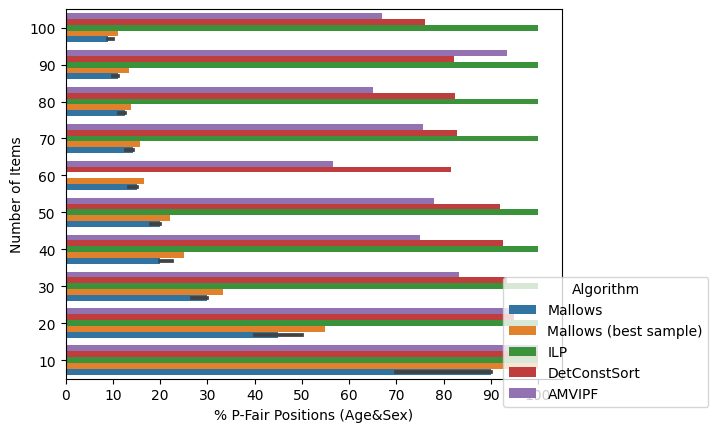

In [116]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x = '% P-Fair Positions (Age&Sex)', y='Number of Items',
            errorbar='ci',
            estimator=np.median,
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'./plots/theta_{theta}_m_{m}_v_{v}/p_pfair', bbox_inches="tight")

#### Age

c:\Users\andre\miniconda3\envs\aif\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\andre\miniconda3\envs\aif\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


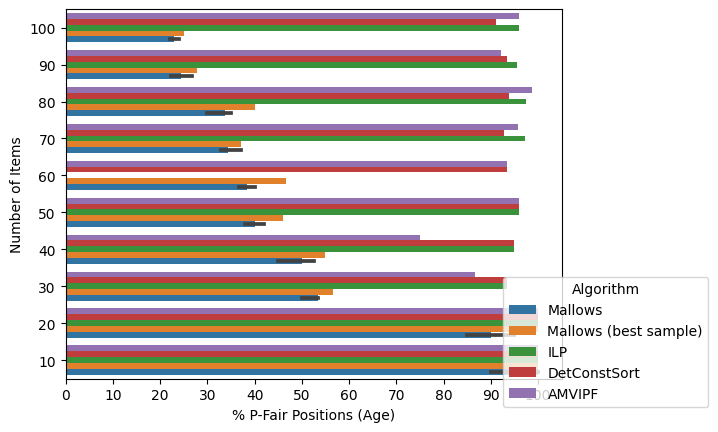

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x = '% P-Fair Positions (Age)', y='Number of Items',
            errorbar='ci',
            estimator=np.median,
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'./plots/theta_{theta}_m_{m}_v_{v}/p_pfair_age', bbox_inches="tight")

##### Sex

c:\Users\andre\miniconda3\envs\aif\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\andre\miniconda3\envs\aif\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


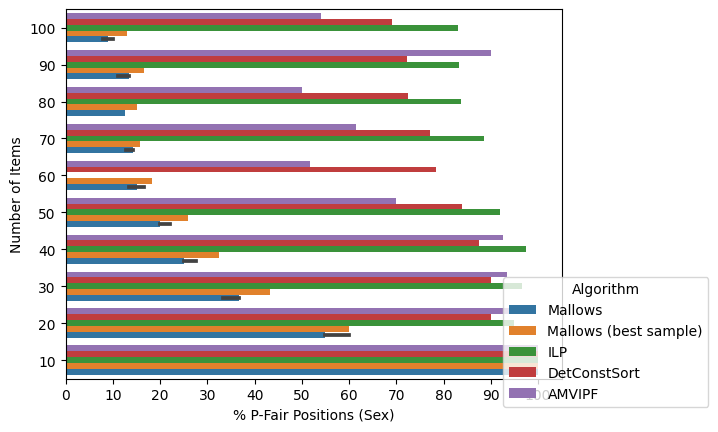

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x = '% P-Fair Positions (Sex)', y='Number of Items',
            errorbar='ci',
            estimator=np.median,
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'./plots/theta_{theta}_m_{m}_v_{v}/p_pfair_sex', bbox_inches="tight")

##### Housing

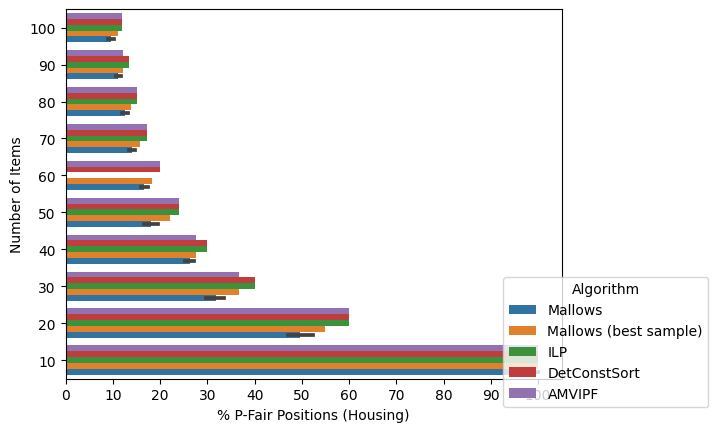

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x = '% P-Fair Positions (Housing)', y='Number of Items',
            errorbar='ci',
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'./plots/theta_{theta}_m_{m}_v_{v}/p_pfair_hou', bbox_inches="tight")

#### NDCG

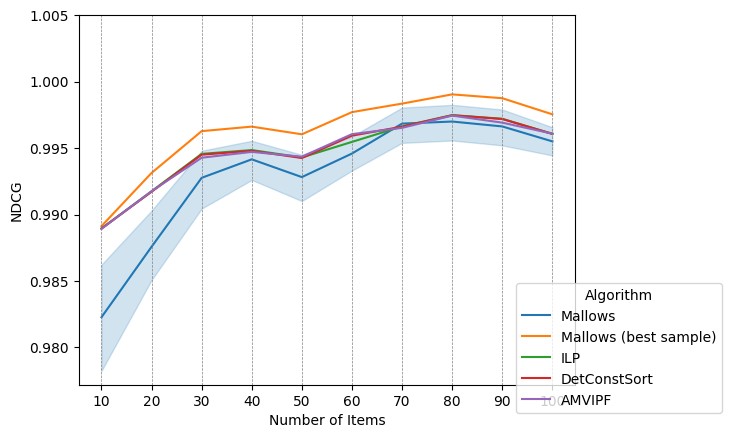

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.lineplot(x='Number of Items', y='NDCG', hue='Algorithm', data=res_df)
# ax.invert_yaxis()
ax.set_xticks(rec_sizes)
for j in rec_sizes:
  ax.axvline(j, color='gray', ls='--',lw=0.5)
ax.set_ylim(ax.get_ylim()[0], 1.005)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
  fig.savefig(f'plots/theta_{theta}_m_{m}_v_{v}/ndcg', bbox_inches="tight")

#### KT Divergence from Center

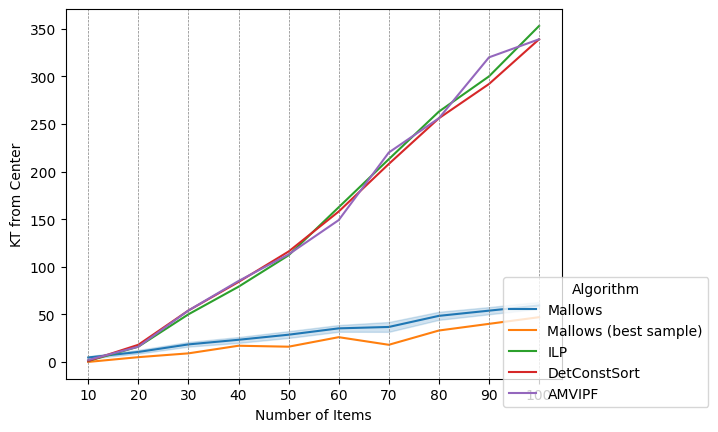

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.lineplot(x='Number of Items', y='KT from Center', hue='Algorithm', data=res_df)
# ax.invert_yaxis()
ax.set_xticks(rec_sizes)
for j in rec_sizes:
  ax.axvline(j, color='gray', ls='--',lw=0.5)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
  fig.savefig(f'plots/theta_{theta}_m_{m}_v_{v}/kt', bbox_inches="tight")

#### % Satisfying minimal representation (100*length/InfIndex)

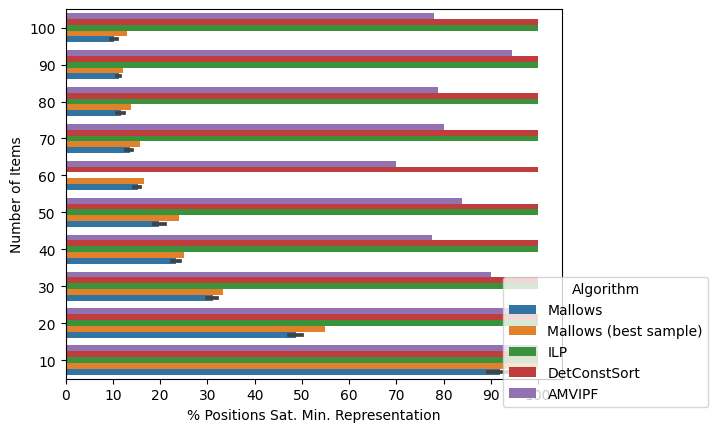

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x = '% Positions Sat. Min. Representation', y='Number of Items',
            errorbar='ci',
            hue = 'Algorithm',data=res_df,
            orient='h')
ax.invert_yaxis()
ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim(0, 105)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
    fig.savefig(f'plots/theta_{theta}_m_{m}_v_{v}/p_minrepr', bbox_inches="tight")

#### InfeasibleIndex

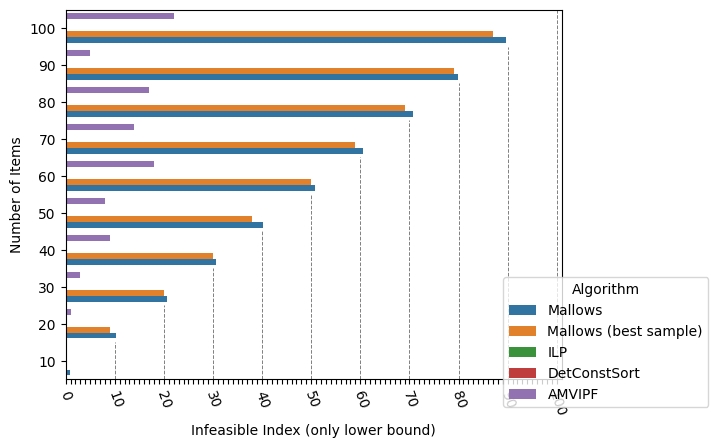

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.barplot(x = 'Infeasible Index', y='Number of Items',
            errorbar=None,
            hue = 'Algorithm',data=res_df,
            orient='h')
for j, r_ in enumerate(rec_sizes):
  ax.axvline(r_,0,(j+1)/len(rec_sizes), ls='--',lw=0.7, c='gray')
ax.set_xticks(np.arange(0,r_+1,step=10))
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-70)
ax.set_xlabel('Infeasible Index (only lower bound)')
ax.set_xticks(range(0, rec_sizes[-1]+1))
ax.set_xlim(0, rec_sizes[-1]+1)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.31, 0.1))

fig = ax.get_figure()
if save:
  fig.savefig(f'plots/theta_{theta}_m_{m}_v_{v}/infind', bbox_inches="tight")

## Approximate Mallows Tests

Approximate Mallows Sampling code adapted from https://github.com/ekhiru/top-k-mallows/ under GPL-3.0

Original code is not available (or doesn't work) as a python package

### Compare with exact sampling

In [ ]:
import pandas as pd

def approximate_mallows(center: pd.DataFrame, theta: int):
    center_ind = np.array(center.index)
    sample = mk_sample(m=1, n=len(center_ind), theta=theta, s0=center_ind)[0]
    return center.loc[sample]

In [ ]:
center=pd.Series([1,2,3,4,5,6,7,8])
theta=0
mm = MallowsModelGenerator(theta=theta, sigma0=center)

In [ ]:
n=5000
sum1 = 0
sum2 = 0
list_kt_exact = []
list_kt_approx = []
for j in range(n):
    sample1 = mm.sample(center)
    sample2 = mallows_sample(s0=center, theta=theta)
    kt_exact = KT(sample1, center)
    kt_approx = KT(list(sample2), center)
    sum1 += kt_exact
    sum2 += kt_approx
    list_kt_exact.append(kt_exact)
    list_kt_approx.append(kt_approx)

In [ ]:
import seaborn as sns
plot = sns.histplot({'Exact': list_kt_exact, 'Approximate': list_kt_approx}, multiple='dodge', discrete=True)
leg = plot.get_legend()
leg.set_title(f'KT from Center, len={len(center)},\ntheta={theta}, {n} experiments')
print(f'exact mean KT from center: {sum1/n}')
print(f'approx mean KT from center: {sum2/n}')
plot

## RAPF Paper Doubts

#### Example 3.1

In Example 3.1 from the paper, they give a ranking that they claim satisfies the minimal representation bound - but, as far as I can tell, it does not.

In [54]:
names = ['Molly' ,'Amy', 'Abi', 'Kim', 'Lee', 'Park', 'Kabir', 'Damien', 'Andres', 'Aaliyah', 'Kiara', 'Jazmine']
scores_m1 = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
scores_m2 = 13 - np.array([3,2,5,7,9,1,4,6,8,10,11,12])
sen = ['j']*3 + ['m']*4 + ['s'] *5
sex = ['f', 'f', 'f', 'm', 'm', 'm', 'm', 'm', 'm', 'f', 'f', 'f']
pos_ind = np.arange(1,13)
n = len(names)

rapf = pd.DataFrame({'score_m1': scores_m1, 'score_m2': scores_m2, 'sex': sex,
                     'seniority': sen, 'name': names, 'pos_ind': pos_ind},index=names)
rapf_groups = [{'seniority': 'j'}, {'seniority': 'm'}, {'seniority': 's'}]

Count number of violations of the lower bound:

In [91]:
index_ex31 = ['Molly','Amy','Kim','Damien',
              'Abi','Lee','Andres','Park','Aaliyah','Kabir','Kiara','Jazmine']
df_ex31 = rapf.loc[index_ex31]
ii = infeasible_index(df_ex31, rapf_groups, [3/n,4/n,5/n], control_upper=False,verbose=True)
print(f'Infeasible Index (N violations of lower bound): {ii}')

Violation on k=3 by group 2: L: 1.0 Act: 0 U: 2.0
Violation on k=5 by group 2: L: 2.0 Act: 1 U: 3.0
Violation on k=6 by group 2: L: 2.0 Act: 1 U: 3.0
Violation on k=8 by group 2: L: 3.0 Act: 2 U: 4.0
Violation on k=10 by group 2: L: 4.0 Act: 3 U: 5.0
Infeasible Index (N violations of lower bound): 5


#### German Credit

Test the RAPF implementation of DetConstSort on the German Credit dataset.

Define their implementation of DetConstSort (https://github.com/MouinulIslamNJIT/Rank-Aggregation_Proportionate_Fairness/)

In [69]:
import math

def swap(dict,i,j):
    item = dict[i]
    dict[i] = dict[j]
    dict[j] = item

def DetConstSort(S,A,P,kmax, corrected=False):
    counts = {}
    minCounts = {}
    for ai in A:
        counts[ai] = 0
        minCounts[ai] = 0

    rankedAttList = {}
    rankedScoreList = {}
    maxIndices = {}
    lastEmpty = 0
    k = 0

    while lastEmpty <= kmax:
        k = k + 1
        tempMinCounts = {}
        for ai in A:
            tempMinCounts[ai] = math.floor(k * P[ai])
        changedMins = []
        for ai in A:
            if minCounts[ai ] < tempMinCounts[ai] and counts[ai] < len(S[ai]):
                changedMins.append((S[ai][counts[ai]],ai))
        if len(changedMins) != 0:
            changedMins.sort(reverse=True)
        for sai,ai in  changedMins:
            # if lastEmpty == kmax:
            #     break
            rankedAttList[lastEmpty] = ai

            rankedScoreList[lastEmpty] = S[ai][counts[ai]]
            # the error:
            if corrected:
              maxIndices[lastEmpty] = k-1
            else:
              maxIndices[lastEmpty] = k
            start = lastEmpty
            while start > 0 and maxIndices[start - 1] >= start and rankedScoreList[start-1] < rankedScoreList[start]:
                swap(maxIndices,start - 1,start)
                swap(rankedAttList,start - 1, start)
                swap(rankedScoreList,start - 1, start)
                start = start - 1
            counts[ai] = counts[ai] + 1
            lastEmpty = lastEmpty + 1
        minCounts = tempMinCounts
    return (rankedAttList, rankedScoreList)

Note: the paper does not state clearly what attribute was used as the ranking score; here I use `Credit amount`.

In [93]:
# try their implemenetation on German Credit
A = {'male, >=35', 'female, >=35', 'male, <35', 'female, <35'}
S = {}
P = {'male, >=35': 0.355, 'female, >=35': 0.097, 'male, <35': 0.335, 'female, <35': 0.213}
aif_prop = [0.355, 0.097, 0.335, 0.213]
for group in german_groups:
    q = ' & '.join(
        [f'{s_i}=="{v_i}"' if isinstance(v_i, str) else f'{s_i}=={v_i}'
        for s_i, v_i in group.items()]
        )
    S[', '.join(list(group.values())[::-1])] = german.query(q)['Credit amount'].to_list()

r_ = 50
german_ipf = DetConstSort(S, A, P, r_-1, corrected=False)
german_ipf_df = pd.DataFrame()
german_ipf_df['Sex'] = [x.split(', ')[0] for x in german_ipf[0].values()]
german_ipf_df['Age'] = [x.split(', ')[1] for x in german_ipf[0].values()]
german_ipf_df['Credit amount'] = german_ipf[1]
print('N violations of lower or upper representation bounds:')
print(f'Unmodified from paper:{infeasible_index(german_ipf_df, german_groups, aif_prop)}')

german_ipf = DetConstSort(S, A, P, r_-1, corrected=True)
german_ipf_corrected = pd.DataFrame()
german_ipf_corrected['Sex'] = [x.split(', ')[0] for x in german_ipf[0].values()]
german_ipf_corrected['Age'] = [x.split(', ')[1] for x in german_ipf[0].values()]
german_ipf_corrected['Credit amount'] = german_ipf[1]
print(f'Corrected: {infeasible_index(german_ipf_corrected, german_groups, aif_prop)}')

N violations of lower or upper representation bounds:
Unmodified from paper:20
Corrected: 4


In [88]:
# try the implementation from AIF360 on same data

german_aif = linkedin_alg(items=german, groups=german_groups, target_prop=aif_prop, score_label='Credit amount', r=50)
print(f'II of AIF implementation: {infeasible_index(german_aif, german_groups, aif_prop)}')

II of AIF implementation: 4


In [104]:
# try Approximate Multi-Valued IPF on the same data

german_amvipf = ApproxMultiValuedIPF(german,pr_attr_name='Age&Sex', score_attr_name='Credit amount', r=50)
print(f'II of AMVIPF: {infeasible_index(german_amvipf, german_groups, aif_prop)}')

II of AMVIPF: 40


Try random data, as they do in their code:

In [83]:
rng = np.random.default_rng(seed=50)
A = {'a','b','c'}
sizes = {}
#generate S
S={}
for a in A:
    size = rng.integers(20, 200)
    sizes[a] = size
    scoreList = []
    for j in range(0,size):
        score = rng.integers(0, 10000)/10000
        scoreList.append(score)
    scoreList.sort(reverse=True)
    S[a] = scoreList

total = sum(sizes.values())
P = {group: sizes[group]/total for group in A}
# print(S)
# print(A)
# print(P)
# print(total)

dcs = DetConstSort(S, A, P, kmax=70)
res_uncor = pd.DataFrame()
res_uncor['group'] = dcs[0]
res_uncor['score'] = dcs[1]

dcs_cor = DetConstSort(S, A, P, kmax=70, corrected=True)
res_cor = pd.DataFrame()
res_cor['group'] = dcs_cor[0]
res_cor['score'] = dcs_cor[1]

Note: Sometimes the output of the AIF implementation and the corrected RAPF implementation might be very slightly different due to how elements with same score in different groups are sorted

In [84]:
items = pd.DataFrame()
groups = []
scores = []
for a in A:
  groups += [a]*sizes[a]
  scores += S[a]
items['group'] = groups
items['score'] = scores

groups = [{'group': 'a'}, {'group': 'b'}, {'group': 'c'}]

items.sort_values(by='score', ascending=False, inplace=True)
res_aif = linkedin_alg(items=items, groups=groups,target_prop=[P['a'], P['b'], P['c']], score_label='score', r=71)
print('Number of positions NOT satisfying p-fairness:')
print(f'IPF paper, unmodified: {infeasible_index(res_uncor, groups, [P["a"], P["b"], P["c"]])}')
print(f'IPF paper, corrected: {infeasible_index(res_cor, groups, [P["a"], P["b"], P["c"]])}')
print(f'AIF360: {infeasible_index(res_aif, groups, [P["a"], P["b"], P["c"]])}')
# print('NDCG:')
# print(ndcg(res_uncor['score'], items['score']))
# print(ndcg(res_ours['score'], items['score']))

Number of positions NOT satisfying p-fairness:
IPF paper, unmodified: 28
IPF paper, corrected: 7
AIF360: 8
